## 1. ABOUT GPT CONFIG I AM USING AND text_data

In [6]:
import torch
import tiktoken


with open("the-verdict.txt","r",encoding='utf-8') as f:
    text_data = f.read()
    
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size 
    "context_length": 256,  # Context length  gpt2 uses 1024 
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


train_ratio = 0.90
num_epochs = 10
train_book = "Every effort moves you"


In [7]:
tokenizer = tiktoken.get_encoding("gpt2")

total_characters = len(text_data)
print("Characters:", total_characters)

total_tokens = len(tokenizer.encode(text_data))
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


## 2. IMPLEMENTING DATA LOADER

In [8]:
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self,text,tokenizer,context_size,stride):
        self.input_ids =[]
        self.target_ids = []
        
        token_ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
    
        for i in range(0, len(token_ids) - context_size,stride):
        
            input_chunk = token_ids[i:i+context_size]
            target_chunk = token_ids[i+1:i+context_size+1]
            
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)  #helpful as total size it give of dataset and user give batch size in DataLoader so we can get #of batches
    
    def __getitem__(self,idx):
        return self.input_ids[idx] , self.target_ids[idx]
    
    
def CreateDataloaderV1(text,context_size,batch_size,stride,shuffle,drop_last,num_workers):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = GPTDatasetV1(text,tokenizer,context_size,stride)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    
    return dataloader


#Example usage

    
dataloader = CreateDataloaderV1(text_data, context_size=6, batch_size=2, stride=3, shuffle=True, drop_last=True, num_workers=0)

dataloader_iter = iter(dataloader)

first_batch = next(dataloader_iter)
print(first_batch)

inputs, targets = first_batch
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)
        

[tensor([[15830,   326,   484,   815, 25722,   683],
        [  286,   502,   438,    40,   550,   655]]), tensor([[  326,   484,   815, 25722,   683,    13],
        [  502,   438,    40,   550,   655,  8197]])]
Inputs:
 tensor([[15830,   326,   484,   815, 25722,   683],
        [  286,   502,   438,    40,   550,   655]])

Targets:
 tensor([[  326,   484,   815, 25722,   683,    13],
        [  502,   438,    40,   550,   655,  8197]])


## 3. SPLIT OF DATA INTO TRAIN AND VALIDATION

In [9]:
# Train/validation ratio
# train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = CreateDataloaderV1(
    train_data,
    context_size=GPT_CONFIG_124M["context_length"],
    batch_size=2,   #batch size is small to reduce memory usage and computational resource demand , model like LLAMA uses 1024
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = CreateDataloaderV1(
    val_data,
    context_size=GPT_CONFIG_124M["context_length"],
    batch_size=2,
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False,
    num_workers=0
)
    



In [10]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")
    
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [11]:
#check that all data is loaded correctly
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("\nTraining tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


Training tokens: 4608
Validation tokens: 512
All tokens: 5120


## 4. ALL CLASSES USED FOR GPT LLM 

In [12]:
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self,d_in, d_out, n_heads , context_length , dropout_rate, qkv_bias = False):
        super().__init__()
        
        assert (d_out % n_heads ==0),"d_out must be divisible by num_heads"  #assert condition , message
        
        self.d_out = d_out
        self.n_heads = n_heads
        self.context_length = context_length
        self.head_dim = d_out // n_heads
        self.qkv_bias = qkv_bias
        self.scale = self.head_dim ** -0.5
        
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.W_query = torch.nn.Linear(d_in, d_out , bias = qkv_bias)
        self.W_key = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
        self.W_value = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
        self.out_proj = torch.nn.Linear(d_out,d_out)
        self.register_buffer("mask", torch.triu( torch.ones(context_length,context_length) ,diagonal = 1))
        # Register a buffer for the mask to ensure it is moved to the correct device during training
        
    
    def forward(self,x):
        batch_size,num_tokens,d_in = x.shape
        
        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        
        # We implicitly split the matrix by adding a `n_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        queries = query.view(batch_size, num_tokens, self.n_heads, self.head_dim)
        keys = keys.view(batch_size, num_tokens, self.n_heads, self.head_dim) 
        values = values.view(batch_size, num_tokens, self.n_heads, self.head_dim)
        
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attention_scores = queries @ keys.transpose(2,3)
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        # Use the mask to fill attention scores
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        
        attention_weights = torch.softmax(attention_scores * self.scale, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attention_weights @ values).transpose(1, 2) 
        
        # Shape: (b, num_tokens, d_out)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, self.d_out)
        
        context_vec = self.out_proj(context_vec)
        
        return context_vec
        
                    
class LayerNorm(torch.nn.Module):
    
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self,x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        normalized_x = (x - mean) / torch.sqrt(var + self.eps)
        
        return self.scale * normalized_x + self.shift
    
       
class GELU(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))    
    
class FeedForward(torch.nn.Module):
    
    def __init__(self,cfg):
        super().__init__()
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )  
        
    def forward(self, x):
        return self.layers(x)
    
          
class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            n_heads=cfg["n_heads"], 
            context_length=cfg["context_length"],
            dropout_rate =cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.dropout = torch.nn.Dropout(cfg["drop_rate"])
        
        
    def forward(self,x):
        
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.dropout(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        
        return x
        

class GPTModel(torch.nn.Module):
    
    def __init__(self,cfg):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.postion_embedding = torch.nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_embedding = torch.nn.Dropout(cfg["drop_rate"])
        
        self.transformer_blocks = torch.nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = torch.nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias = False)
        
    
    def forward(self,in_idx):
        batch_size , seq_len = in_idx.shape
        token_emb = self.token_embedding(in_idx)
        pos_emb = self.postion_embedding(torch.arange(seq_len, device=in_idx.device))
        x = token_emb + pos_emb  # Shape [batch_size, num_tokens, emb_size]
        
        x = self.drop_embedding(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        

## 5. BUILDING OF MODEL

In [13]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [14]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


## 6. TRAINING LOOP FOR THE LLM

In [15]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

# def generate_and_print_sample(model, tokenizer, device, start_context):
#     model.eval()
#     context_size = model.postion_embedding.weight.shape[0]
#     encoded = text_to_token_ids(start_context, tokenizer).to(device)
#     with torch.no_grad():
#         token_ids = generate_text_simple(
#             model=model, idx=encoded,
#             max_new_tokens=50, context_size=context_size
#         )
#     decoded_text = token_ids_to_text(token_ids, tokenizer)
#     print(decoded_text.replace("\n", " "))  # Compact print format
#     model.train()

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.postion_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=text_to_token_ids("Every effort moves you", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=25,
            temperature=1.4
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()
    
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [16]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)


train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=train_book, tokenizer=tokenizer
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you. had I the the the in., of and with of my--
Ep 2 (Step 000010): Train loss 6.649, Val loss 7.037
Ep 2 (Step 000015): Train loss 6.128, Val loss 6.600
Every effort moves you's him, of, it aI the the my, I. 
Ep 3 (Step 000020): Train loss 6.365, Val loss 6.882
Ep 3 (Step 000025): Train loss 5.553, Val loss 6.474
Every effort moves you it, his. "-- his! his to's, of. 
Ep 4 (Step 000030): Train loss 5.331, Val loss 6.442
Ep 4 (Step 000035): Train loss 4.748, Val loss 6.428
Every effort moves you, on and down"I on of the to have to a throughI
Ep 5 (Step 000040): Train loss 4.482, Val loss 6.301
Every effort moves you's for to have to see."     I that and
Ep 6 (Step 000045): Train loss 3.961, Val loss 6.196
Ep 6 (Step 000050): Train loss 3.536, Val loss 6.143
Every effort moves you't  "Oh on on glanced of jealousy, but it. "
Ep 7 (Step 000055): Train loss 3.319, Va

## 7. PLOT THE PERFORMANCE

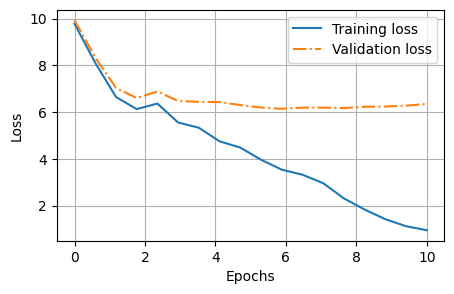

In [17]:
import matplotlib.pyplot as plt


def plot_losses(epochs_seen, train_losses, val_losses):
    plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    plt.plot(epochs_seen, train_losses, label="Training loss")
    plt.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.grid()
    plt.legend()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, train_losses, val_losses)

## 8. SAVING OF WEIGHTS

In [ ]:
import os
MAIN_DIR = os.getcwd()
print(MAIN_DIR)

model_path = os.path.join(MAIN_DIR, "model.pth")

model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), model_path)

print("Model loaded from:", model_path)

/Users/somesh/Desktop/IITH_PROJECTS/GPT2_FROM_SCRATCH
Model loaded from: /Users/somesh/Desktop/IITH_PROJECTS/GPT2_FROM_SCRATCH/model.pth


In [21]:
model.load_state_dict(torch.load(model_path))
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (postion_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(